In [1]:
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.7.1
Populating the interactive namespace from numpy and matplotlib


# Loading Dataset Test

In [2]:
DATASET_PATH = '/home/greenstar/sensorcloud/LSTM-playground/coin_desk_data.csv'

coin = pd.read_csv(DATASET_PATH)
coin = coin.set_index('Timestamp')
coin

,Close,Open,High,Low
Timestamp,,,,
2013-10-01,123.654990,124.304660,124.751660,122.563490
2013-10-02,125.455000,123.654990,125.758500,123.633830
2013-10-03,108.584830,125.455000,125.665660,83.328330
2013-10-04,118.674660,108.584830,118.675000,107.058160
2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...
2021-01-08,39713.507857,36806.419755,40324.014033,36356.430756
2021-01-09,40519.448598,39420.800696,41962.362125,36741.330177
2021-01-10,40258.923989,40558.102123,41375.430681,38766.276161


<AxesSubplot:xlabel='Timestamp'>

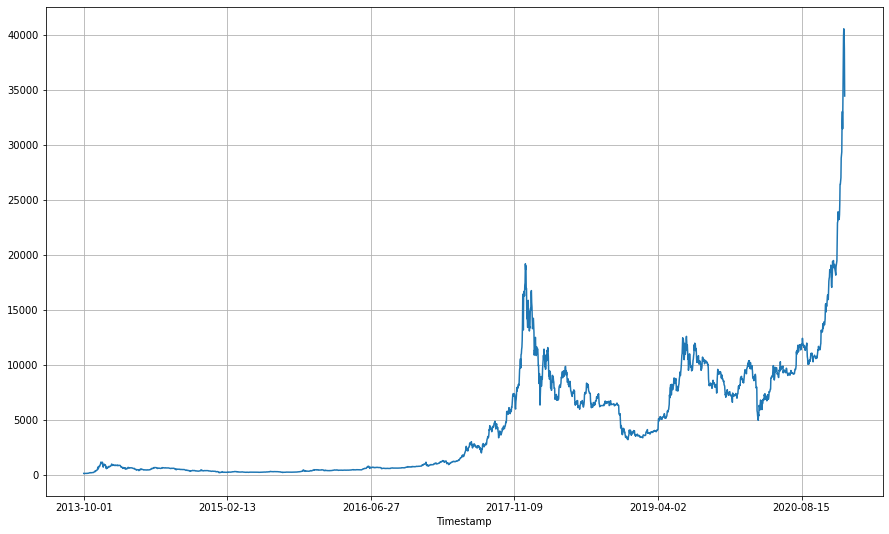

In [3]:
coin.Close.plot(grid=True)

In [4]:
coin.tail()
print(coin.isna().sum())

Close    0
Open     0
High     0
Low      0
dtype: int64


# Data Preparation

In [5]:
class CoinDataset(Dataset):
    def __init__(self, csv_path, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        _time_start = datetime.datetime(*start)
        _time_end = datetime.datetime(*end)
        _start = _time_start.strftime('%Y-%m-%d')
        _end = _time_end.strftime('%Y-%m-%d')

        _data = pd.read_csv(csv_path)
        _data = _data.set_index('Timestamp')
        _data = _data[_start:_end]
        self.data = _data

        #print(self.data.isna().sum())
        print(len(self.data))
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close', 'Open', 'High', 'Low']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y




In [6]:
# Model Define
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [7]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Train, Validate, Test 

In [8]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 0].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [9]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 0].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [10]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 0].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            #print(f'y_pred: {y_pred}')
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [11]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc

    # ======= Save Model Data ======= #
    SAVE_PATH = './models/test2.tar'
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'args': args,
            'result': result
            }, SAVE_PATH)

    return vars(args), result

# Manage Experiment

In [12]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [13]:

def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [16]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.csv_path = '/home/greenstar/sensorcloud/LSTM-playground/coin_desk_data.csv'
args.batch_size = 128
args.x_frames = 64
args.y_frames = 8

# ====== Model Capacity ===== #
args.input_dim = 4
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, Adam...
args.lr = 0.0001
args.epoch = 100


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.0001] # [0.001, 0.0001, 0.00001]
list_var2 = [4]


# ====== Dataset Prep ====== #
trainset = CoinDataset(args.csv_path, args.x_frames, args.y_frames, (2013,10,1), (2018,10,1))
valset = CoinDataset(args.csv_path, args.x_frames, args.y_frames, (2018,10,1), (2020,1,1))
testset = CoinDataset(args.csv_path, args.x_frames, args.y_frames, (2020,1,1), (2021,1,12))
partition = {'train': trainset, 'val':valset, 'test':testset}


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

1820
455
378
Namespace(batch_size=128, csv_path='/home/greenstar/sensorcloud/LSTM-playground/coin_desk_data.csv', device='cuda', dropout=0.0, epoch=100, exp_name='exp4', hid_dim=50, input_dim=4, l2=1e-05, lr=0.0001, n_layers=4, optim='Adam', use_bn=True, x_frames=64, y_frames=8)
Epoch 0, Acc(train/val): 5.89/5.74, Loss(train/val) 0.01322/0.01109. Took 4.34 sec
Epoch 1, Acc(train/val): 5.55/5.27, Loss(train/val) 0.01264/0.01076. Took 4.33 sec
Epoch 2, Acc(train/val): 5.25/4.92, Loss(train/val) 0.01225/0.01045. Took 4.36 sec
Epoch 3, Acc(train/val): 5.00/4.65, Loss(train/val) 0.01196/0.01021. Took 4.33 sec
Epoch 4, Acc(train/val): 4.81/4.45, Loss(train/val) 0.01162/0.01002. Took 4.33 sec
Epoch 5, Acc(train/val): 4.66/4.36, Loss(train/val) 0.01142/0.00994. Took 4.36 sec
Epoch 6, Acc(train/val): 4.54/4.25, Loss(train/val) 0.01120/0.00985. Took 4.37 sec
Epoch 7, Acc(train/val): 4.42/4.42, Loss(train/val) 0.01097/0.00984. Took 4.37 sec
Epoch 8, Acc(train/val): 4.31/4.35, Loss(train/val) 0.01

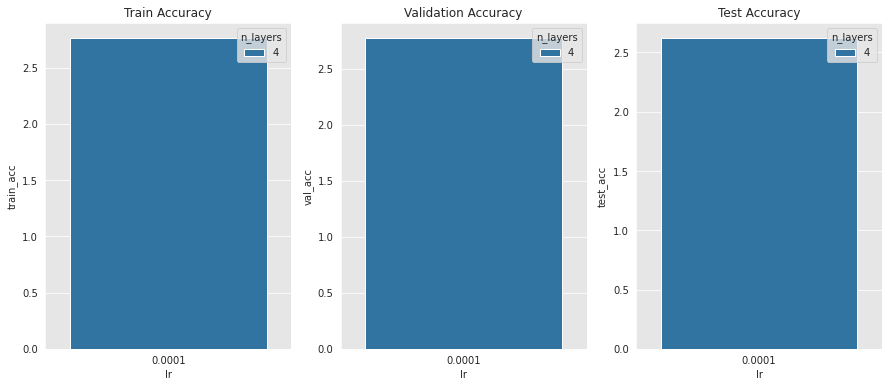

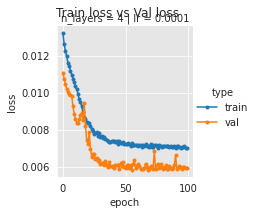

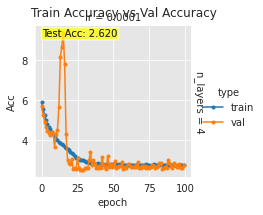

In [17]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp4')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)